`Name: Mohamed Mosa Aboelftoh`

`AI-Intake 2 Mansoura`

---

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix



In [4]:
import warnings
warnings.filterwarnings("ignore")

# Load dataset

After some preprossceing on data in the lab linear regreasion. i seved this cleaned version of House Price Dataset

In [3]:

df_churn = pd.read_csv('Churn_Modelling.csv')
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [13]:
df_churn.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## visuals   

In [14]:
## separating the categorical features and numerical features
num_cols = list(set(df_churn.describe().columns.to_list()) - set(['CustomerId']))
cat_cols = list(set(df_churn.columns.to_list()) - set(num_cols) - set(['CustomerId']) - set(['Surname']))

In [15]:

df_list=[]
for cat_column in cat_cols:
    df_list.append(df_churn.groupby([cat_column])['CustomerId'].count().reset_index().rename(columns = {'CustomerId' : 'count'}))

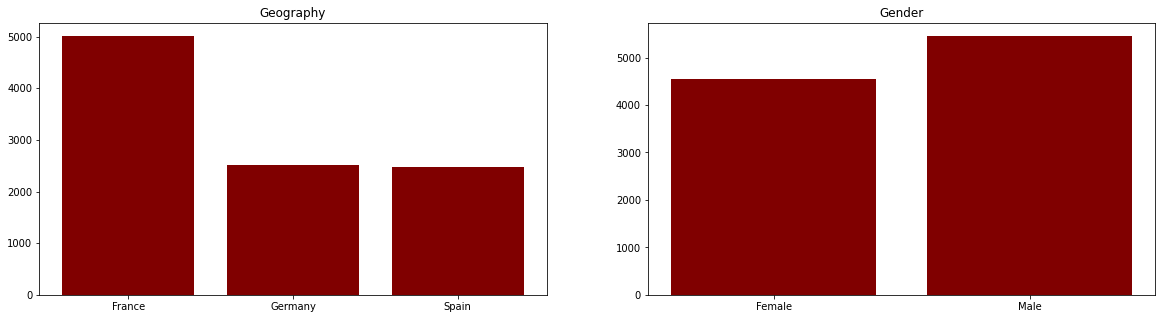

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
i=0
j=0
for df in df_list:
    axes[j].bar(df.iloc[:, 0],df.iloc[:, 1], color ='maroon')
    axes[j].set_title(df.columns[0])
    if(j<1):
        j+=1
plt.show()

array([[<AxesSubplot:title={'center':'Exited'}>,
        <AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'Balance'}>],
       [<AxesSubplot:title={'center':'RowNumber'}>,
        <AxesSubplot:title={'center':'CreditScore'}>,
        <AxesSubplot:title={'center':'Tenure'}>],
       [<AxesSubplot:title={'center':'IsActiveMember'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'HasCrCard'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

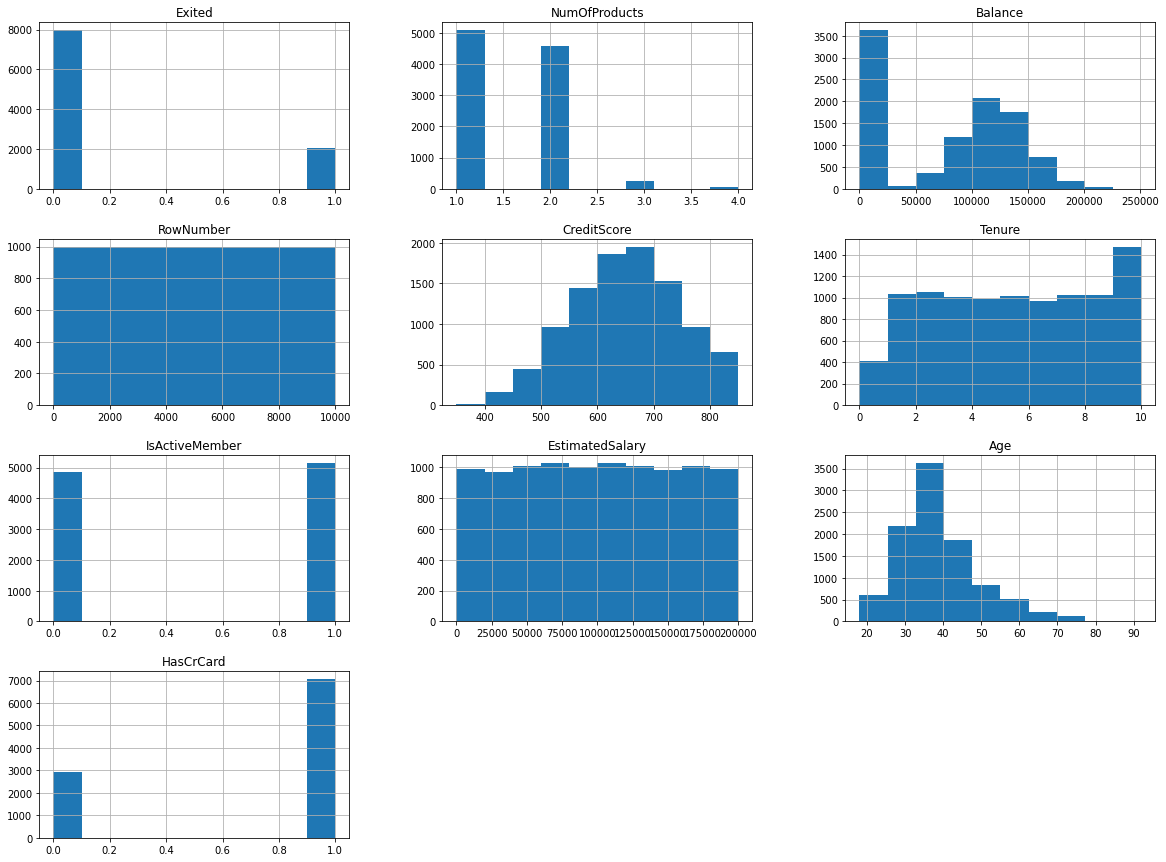

In [17]:
df_churn[num_cols].hist(figsize=(20,15))

<AxesSubplot:xlabel='Age', ylabel='Count'>

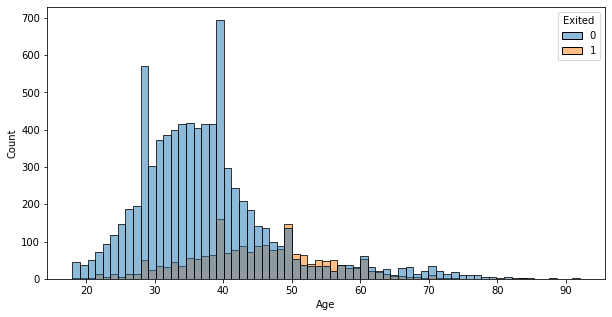

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(df_churn, x='Age', hue='Exited')

In [19]:
num_cols

['Exited',
 'NumOfProducts',
 'Balance',
 'RowNumber',
 'CreditScore',
 'Tenure',
 'IsActiveMember',
 'EstimatedSalary',
 'Age',
 'HasCrCard']

<AxesSubplot:xlabel='IsActiveMember'>

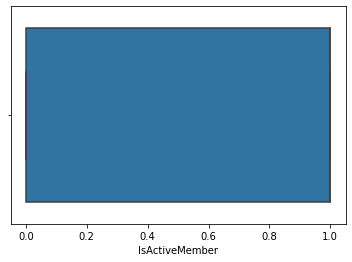

In [20]:

    sns.boxplot(df_churn['IsActiveMember'])

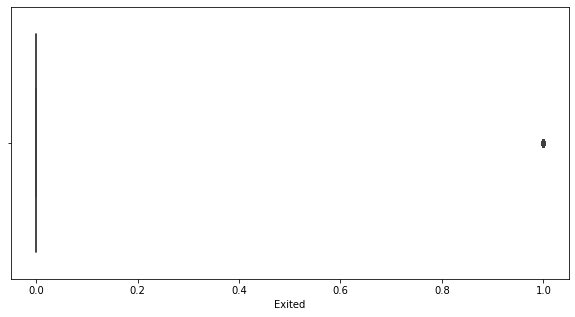

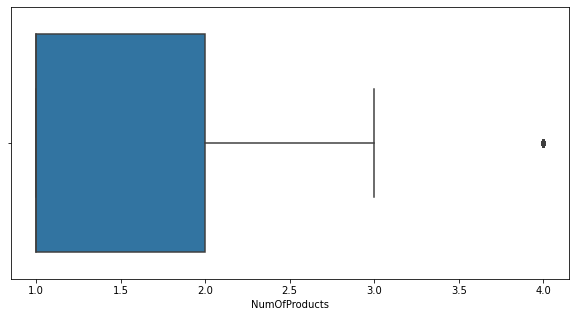

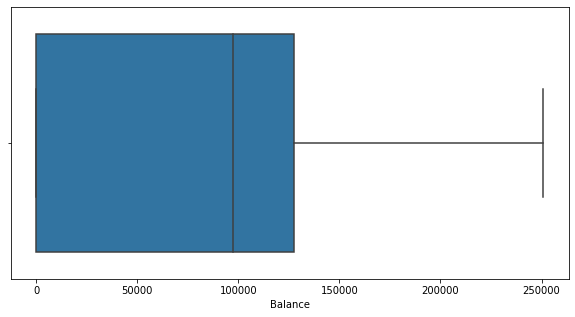

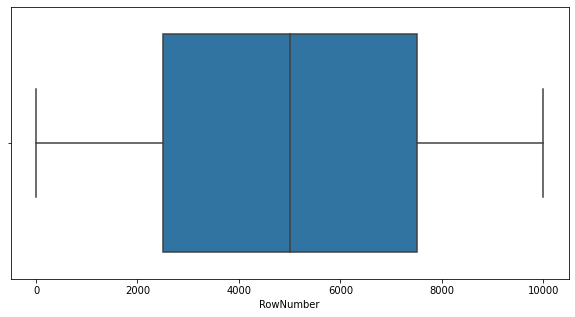

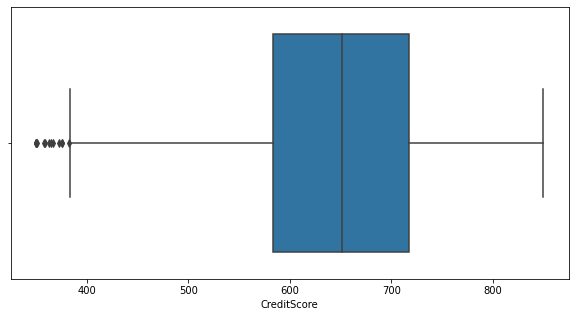

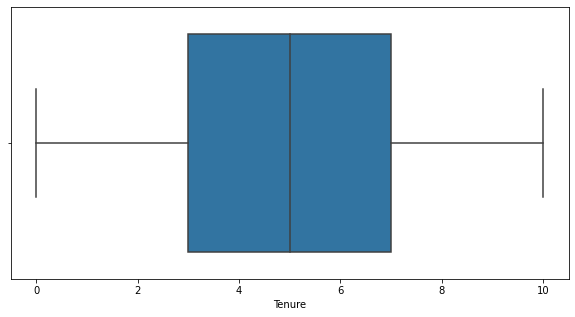

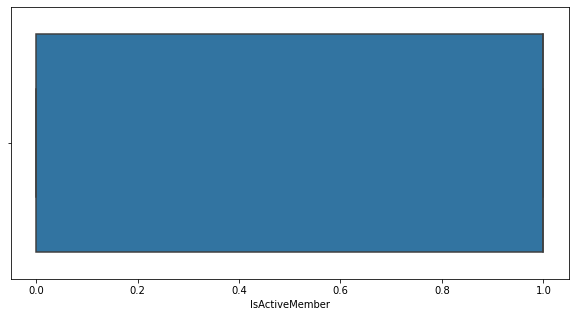

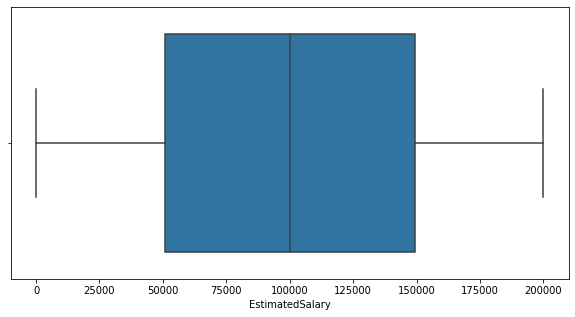

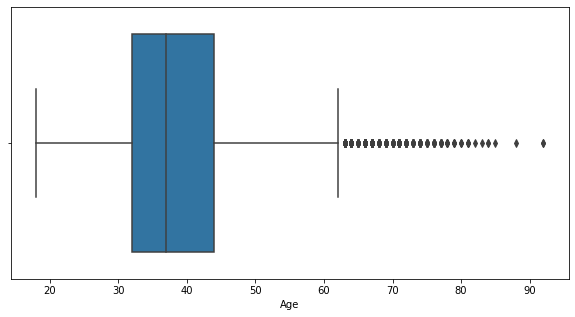

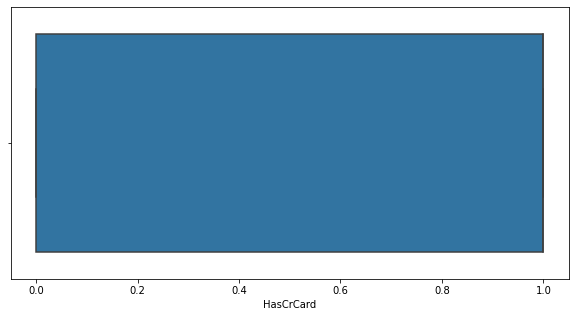

In [21]:

for col in num_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(df_churn[col])

## preprocessing 

In [5]:
## separating the categorical features and numerical features
num_cols = list(set(df_churn.describe().columns.to_list()) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))
cat_cols = list(set(df_churn.columns.to_list()) - set(num_cols) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))

In [6]:
def bounds_calc(df, col):
    Q1 = np.percentile(df[col], q = 25, interpolation = 'midpoint')
    Q3 = np.percentile(df[col], q = 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    Upper_Bound = Q3 + 5*IQR
    Lower_Bound = Q1 - 5*IQR
    return Lower_Bound, Upper_Bound

def outliers_clamping(Lower_Bound, Upper_Bound, value):
    if value > Upper_Bound:
        return Upper_Bound
    elif value < Lower_Bound:
        return Lower_Bound
    else:
        return value

def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    df['diff_col'] = df[col] - mean_col
    df['diff_col_powered'] = np.power(df['diff_col'], 3)
    skewness = np.sum(df['diff_col_powered'])/((size_rows - 1) * np.power(std_col, 3))
    df.drop(columns = ['diff_col_powered', 'diff_col'], inplace = True)
    return skewness

def skewed_data_transformation(value):
    return np.log(1 + np.abs(value))

# outliers handling
for col in num_cols:
    Lower_Bound, Upper_Bound = bounds_calc(df_churn, col)
    df_churn[col] = df_churn[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))

# skewness handling
skewed_cols = []
for col in num_cols: 
    sk = skewness_calc(col, df_churn)
    if (np.abs(sk) >= 1):
        skewed_cols.append(col)
        df_churn[col] = df_churn[col].apply(lambda x : skewed_data_transformation(x))

In [7]:

num_cols = list(set(df_churn.describe().columns.to_list()) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))
cat_cols = list(set(df_churn.columns.to_list()) - set(num_cols) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))

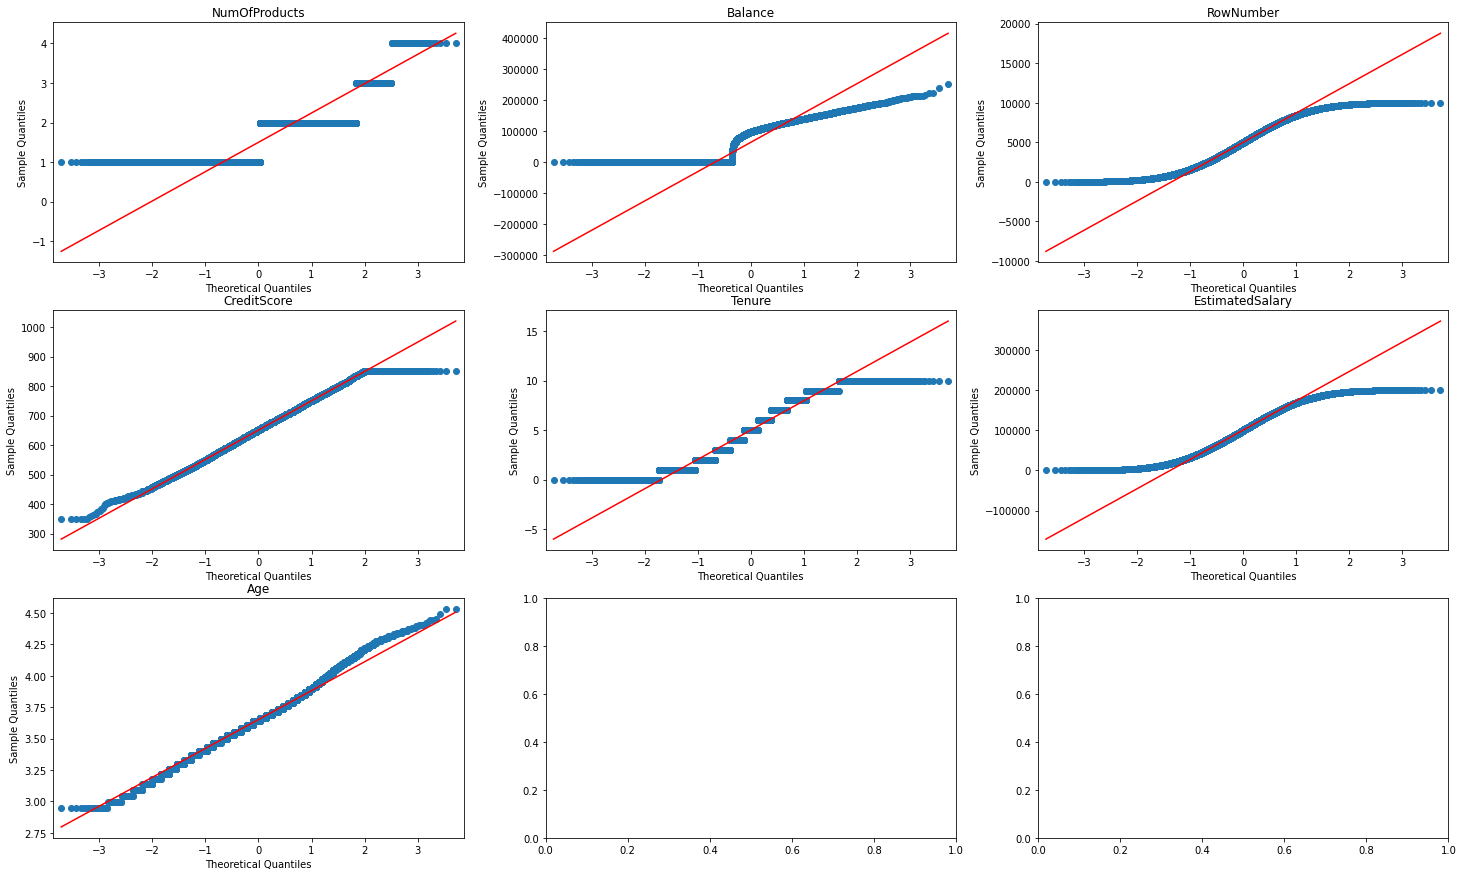

In [25]:

ncols = 3
nrows=3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(25, 15))
i=0
j=0
for col in num_cols:
    sm.qqplot(df_churn[col],fit = False, line='q', ax = axes[i, j])
    axes[i, j].set_title(col)
    if(j<ncols-1):
        j+=1
    else:
        i+=1
        j=0
plt.show()

In [8]:
feats_std_scale = []
feats_min_max_scale = []
sample_data  = df_churn.sample(replace = False, n= 500)

from scipy.stats import shapiro
for col in num_cols:
    stat, p = shapiro(sample_data[col])
    print('W_Statistic=%.3f, p=%.8f' % (stat, p))

    alpha = 0.001
    if p > alpha:
        print(f'{col} looks like gaussian (fail to reject H0)')
        feats_std_scale.append(col)
    else:
        print(f'{col} does not look Gaussian (reject H0)')
        feats_min_max_scale.append(col)


min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
# fitting
min_max_scaler_model = min_max_scaler.fit(df_churn[feats_min_max_scale])
std_scaler_model = std_scaler.fit(df_churn[feats_std_scale])
# transforming min_max_scale
min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(df_churn[feats_min_max_scale]), columns = feats_min_max_scale)

# tranforming std_scale
std_scaled_train_data =pd.DataFrame( std_scaler_model.transform(df_churn[feats_std_scale]), columns = feats_std_scale)

W_Statistic=0.991, p=0.00560222
Age looks like gaussian (fail to reject H0)
W_Statistic=0.837, p=0.00000000
Balance does not look Gaussian (reject H0)
W_Statistic=0.954, p=0.00000000
EstimatedSalary does not look Gaussian (reject H0)
W_Statistic=0.946, p=0.00000000
RowNumber does not look Gaussian (reject H0)
W_Statistic=0.944, p=0.00000000
Tenure does not look Gaussian (reject H0)
W_Statistic=0.993, p=0.02149647
CreditScore looks like gaussian (fail to reject H0)
W_Statistic=0.719, p=0.00000000
NumOfProducts does not look Gaussian (reject H0)


In [9]:
# label encoding of the Gender
label_enc_model = LabelEncoder().fit(df_churn['Gender'])
df_churn['Gender'] = label_enc_model.transform(df_churn['Gender'])

one_hot_enc_model = OneHotEncoder(sparse = False).fit(df_churn[['Geography']])
ohe_train_data = one_hot_enc_model.transform(df_churn[['Geography']])

a=one_hot_enc_model.categories_
col_names=[]
for list_ in a:
    for element in list_:
        col_names.append(element)

nominal_train_df = pd.DataFrame(ohe_train_data, columns = col_names)

nominal_train_df = nominal_train_df.merge(df_churn[['Gender']], right_index = True, left_index = True)

num_train_df = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)\
                  .merge(df_churn[['HasCrCard', 'Exited', 'IsActiveMember']], right_index = True, left_index = True)


final_train_data = nominal_train_df.merge(num_train_df, right_index = True, left_index = True, how = 'inner')


In [10]:
print(len(final_train_data[final_train_data['Exited'] == 1])/ len(final_train_data))

rare_class_data = final_train_data[final_train_data['Exited'] == 1]
dominant_class_data = final_train_data[final_train_data['Exited'] == 0]

under_sampled_class = dominant_class_data.sample(frac = 0.25, replace = False, random_state = 2022)
train_undersampled = pd.concat((under_sampled_class, rare_class_data), axis = 0)

print(len(train_undersampled[train_undersampled['Exited'] == 1])/ len(train_undersampled))

0.2037
0.5057100297914597


# Splitting The data

In [11]:
# final_train_data, final_test_data
X = train_undersampled.drop(columns =['Exited'])
Y = train_undersampled[['Exited']]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=42)

# Implemint The Model

## logistic regression

In [1]:
def initialize(X, bias = True):
    if bias:
      weights = np.zeros((X.shape[1]+1,1))
      X = np.c_[np.ones((X.shape[0],1)),X]
    else:
      weights = np.zeros((X.shape[1],1))
    return weights,X


sigmoid = lambda z : 1/(1 + np.e**(-z))

def cost(X, y, theta):
    z = np.dot(X,theta)
    cost0 = y.T.dot(np.log(sigmoid(z)))
    cost1 = (1-y).T.dot(np.log(1-sigmoid(z)))
    cost = -((cost1 + cost0))/len(y) 
    return cost

def fit(X, y, lr=0.001, bias = True, max_iterations=100):
  params,X = initialize(X, bias)
  for i in range(max_iterations):
      params = params - lr * np.dot(X.T, sigmoid(np.dot(X,params)) - np.reshape(y,(len(y),1)))
  return params

def predict(X, optimum_weights, bias = True, threshold = 0.5):
  z = np.dot(initialize(X, bias)[1], optimum_weights)
  preds = []
  for i in sigmoid(z):
      if i>threshold:
          preds.append(1)
      else:
          preds.append(0)
  return preds

Fit model, predict new value, and clc the accuracy score

In [31]:
theta = fit(X_train, y_train, lr=0.001, bias = True, max_iterations=100)
logistic_y_pred = predict(X_val, theta, bias = True, threshold = 0.77)
accuracy_score(logistic_y_pred, y_val)

0.6218045112781955

ROC curve 

In [28]:
model = LogisticRegression(max_iter= 100, fit_intercept= True).fit(X_train, y_train)

y_pred_sklearn = model.predict(X_val)

accuracy_score(y_pred_sklearn, y_val)

0.7007518796992481

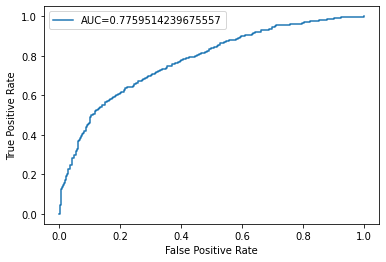

In [26]:

y_pred_proba = model.predict_proba(X_val)[::, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

auc = roc_auc_score(y_val, y_pred_proba)

#create ROC curve showing in the bottom the AUC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=2)
plt.show()

In [30]:
y_pred_proba.shape

(1330,)

## 1. Linear kernel SVM

### What is the best C Parameter

In [75]:
for c in range(1, 21):  # range from 0.2 to 5
    c = c/4
    Model = SVC(kernel='linear', C=c).fit(X_train, y_train)
    SVC_y_pred = Model.predict(X_train)


    print(f'Where C is {c} the score is ' ,accuracy_score(SVC_y_pred, y_train))


Where C is 0.25 the score is  0.7146034099332839
Where C is 0.5 the score is  0.7142327650111193
Where C is 0.75 the score is  0.7138621200889548
Where C is 1.0 the score is  0.7138621200889548
Where C is 1.25 the score is  0.7142327650111193
Where C is 1.5 the score is  0.7138621200889548
Where C is 1.75 the score is  0.7138621200889548
Where C is 2.0 the score is  0.7134914751667902
Where C is 2.25 the score is  0.7142327650111193
Where C is 2.5 the score is  0.7138621200889548
Where C is 2.75 the score is  0.7138621200889548
Where C is 3.0 the score is  0.7142327650111193
Where C is 3.25 the score is  0.7138621200889548
Where C is 3.5 the score is  0.7142327650111193
Where C is 3.75 the score is  0.7142327650111193
Where C is 4.0 the score is  0.7138621200889548
Where C is 4.25 the score is  0.7142327650111193
Where C is 4.5 the score is  0.7142327650111193
Where C is 4.75 the score is  0.7142327650111193
Where C is 5.0 the score is  0.7142327650111193


## 2. Polynomial kernel SVM

### What is the best polynomial degree d, the best C ??

In [39]:
def best_of_C(degree = 1):
    c_params = {}
    for c in range(1, 11):  # range from 0.2 to 5
        c = c/5
        Model = SVC(kernel='poly', degree=degree, C=c, gamma='auto').fit(X_train, y_train)
        SVC_y_pred = Model.predict(X_val)
        c_params[c] = accuracy_score(SVC_y_pred, y_val)
        
    print(c_params)
    max_score = max(c_params.values())
    c = [k for k, v in c_params.items() if v == max_score][0]
    return c, max_score 

In [38]:
def best_of_dgree():
    deg_param = {}
    for deg in range(1,30):
        print('Degree = ', deg, ' every c with the best scor ++>')
        deg_param[deg] = best_of_C(degree = deg)
    
        
    max_score = max(np.array(list(deg_param.values()))[:,1])
    best = [[k, v[0]] for k, v in deg_param.items() if v[1] == max_score]
    best_c = best[0][1]
    best_degree = best[0][0]
    print( f'\n\nThe Best C is {best_c} and  the best degree is {best_degree} which it has max score = {max_score} '  )
    


In [40]:
best_of_dgree()

Degree =  1  every c with the best scor ++>
{0.2: 0.7075187969924812, 0.4: 0.7052631578947368, 0.6: 0.7022556390977444, 0.8: 0.7022556390977444, 1.0: 0.7037593984962406, 1.2: 0.7022556390977444, 1.4: 0.7015037593984963, 1.6: 0.7007518796992481, 1.8: 0.7015037593984963, 2.0: 0.7007518796992481}
Degree =  2  every c with the best scor ++>
{0.2: 0.6962406015037594, 0.4: 0.6947368421052632, 0.6: 0.7, 0.8: 0.6977443609022557, 1.0: 0.6992481203007519, 1.2: 0.6969924812030075, 1.4: 0.6962406015037594, 1.6: 0.693984962406015, 1.8: 0.6954887218045113, 2.0: 0.6954887218045113}
Degree =  3  every c with the best scor ++>
{0.2: 0.675187969924812, 0.4: 0.6864661654135338, 0.6: 0.6902255639097744, 0.8: 0.6977443609022557, 1.0: 0.6992481203007519, 1.2: 0.6984962406015037, 1.4: 0.7007518796992481, 1.6: 0.6992481203007519, 1.8: 0.7007518796992481, 2.0: 0.7015037593984963}
Degree =  4  every c with the best scor ++>
{0.2: 0.5909774436090226, 0.4: 0.643609022556391, 0.6: 0.6556390977443609, 0.8: 0.675187

### 

### 3. What is the best C, and the best Gamma Hyper-parameters ??

with kernel RBF

In [43]:
def best_of_C(gama = 1):
    c_params = {}
    for c in range(1, 25):  # range from 0.2 to 5
        c = c/5
        Model = SVC(kernel='rbf', C=c, gamma=gama).fit(X_train, y_train)
        SVC_y_pred = Model.predict(X_val)
        c_params[c] = accuracy_score(SVC_y_pred, y_val)
        
    # print(c_params, end='\n\n')
    max_score = max(c_params.values())
    c = [k for k, v in c_params.items() if v == max_score][0]
    return c, max_score 

def best_of_gamas():
    gama_param = {}
    for gama in range(1,21):
        gama = gama/100
        print('gama = ', gama, ' C with the best score ++>', end=' ')
        gama_param[gama] = best_of_C(gama= gama)
        print(gama_param[gama])
    
        
    max_score = max(np.array(list(gama_param.values()))[:,1])
    best = [[k, v[0]] for k, v in gama_param.items() if v[1] == max_score]
    best_c = best[0][1]
    best_gama = best[0][0]
    print( f'\n\nThe Best C is {best_c} and the best gama is {best_gama} which it has max score = {max_score}'  )
    
best_of_gamas()

gama =  0.01  every c with the best scor ++>
{0.2: 0.7172932330827068, 0.4: 0.7127819548872181, 0.6: 0.7082706766917293, 0.8: 0.706015037593985, 1.0: 0.7045112781954888, 1.2: 0.7082706766917293, 1.4: 0.706015037593985, 1.6: 0.7045112781954888, 1.8: 0.7022556390977444, 2.0: 0.7022556390977444, 2.2: 0.7045112781954888, 2.4: 0.7022556390977444, 2.6: 0.7015037593984963, 2.8: 0.7022556390977444, 3.0: 0.7030075187969925, 3.2: 0.7022556390977444, 3.4: 0.7030075187969925, 3.6: 0.7030075187969925, 3.8: 0.7037593984962406, 4.0: 0.7045112781954888, 4.2: 0.7037593984962406, 4.4: 0.7045112781954888, 4.6: 0.7045112781954888, 4.8: 0.7030075187969925}

gama =  0.02  every c with the best scor ++>
{0.2: 0.7112781954887218, 0.4: 0.7075187969924812, 0.6: 0.7052631578947368, 0.8: 0.7045112781954888, 1.0: 0.7045112781954888, 1.2: 0.7045112781954888, 1.4: 0.7052631578947368, 1.6: 0.706766917293233, 1.8: 0.706015037593985, 2.0: 0.706015037593985, 2.2: 0.706015037593985, 2.4: 0.7052631578947368, 2.6: 0.709022

### 4. Plot the following curves for the RBF kernel SVM


#### a.	Curve demonstrating the effect of changing C on the F1-score of the train-data

In [69]:
change_of_C = []
for i in range(1, 50):  # range from 0.2 to 5
    c = i/20
    Model = SVC(kernel='rbf', C=c).fit(X_train, y_train)
    SVC_y_pred = Model.predict(X_train)

    change_of_C.append((c,f1_score(SVC_y_pred, y_train)))
df_c = pd.DataFrame(change_of_C, columns=['C', 'F1_Score'])
df_c.head()


,C,F1_Score
0,0.05,0.726634
1,0.10,0.728238
2,0.15,0.730466
3,0.20,0.732384
4,0.25,0.734289


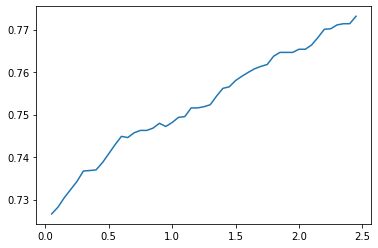

In [70]:
plt.figure(figsize=(10,5))
plt.plot(df_c['C'], df_c['F1_Score'])

#### b.	Curve demonstrating the effect of changing C on the F1-score of the validation-data

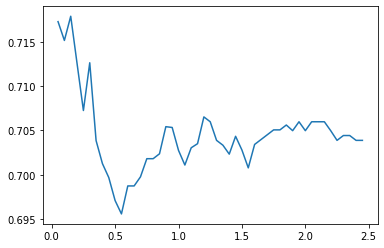

In [71]:
change_of_C = []
for i in range(1, 50):  # range from 0.2 to 5
    c = i/20
    Model = SVC(kernel='rbf', C=c).fit(X_train, y_train)
    SVC_y_pred = Model.predict(X_val)

    change_of_C.append((c,f1_score(SVC_y_pred, y_val)))
df_c = pd.DataFrame(change_of_C, columns=['C', 'F1_Score'])

plt.figure(figsize=(10,5))
plt.plot(df_c['C'], df_c['F1_Score'])


#### c.	Curve demonstrating the effect of changing Gamma on the F1-score of the train-data

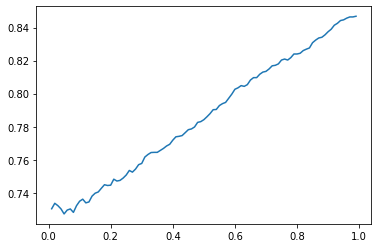

In [72]:
change_of_C = []
for i in range(1, 100):  # range from 0.2 to 5
    c = i/100
    Model = SVC(kernel='rbf', gamma=c).fit(X_train, y_train)
    SVC_y_pred = Model.predict(X_train)

    change_of_C.append((c,f1_score(SVC_y_pred, y_train)))
df_c = pd.DataFrame(change_of_C, columns=['C', 'F1_Score'])

plt.figure(figsize=(10,5))
plt.plot(df_c['C'], df_c['F1_Score'])


#### d.	Curve demonstrating the effect of changing Gamma on the F1-score of the validation-data

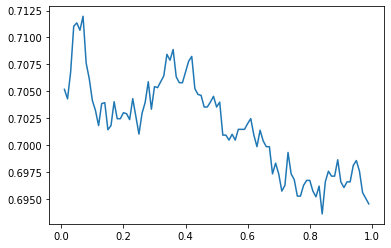

In [73]:
change_of_C = []
for i in range(1, 100):  # range from 0.2 to 5
    c = i/100
    Model = SVC(kernel='rbf', gamma=c).fit(X_train, y_train)
    SVC_y_pred = Model.predict(X_val)

    change_of_C.append((c,f1_score(SVC_y_pred, y_val)))
df_c = pd.DataFrame(change_of_C, columns=['C', 'F1_Score'])

plt.figure(figsize=(10,5))
plt.plot(df_c['C'], df_c['F1_Score'])


## 4.	Compare the best setting of Logistic Regression Model with the best setting of SVM Model and use the best model to release a list of names of users who will probably churn 

#### Logistic Regression Model with the best setting 

In [114]:
model = LogisticRegression(max_iter= 1000, fit_intercept= True).fit(X_train, y_train)

logistic_y_pred = model.predict(X_val)

accuracy_score(y_pred_sklearn, y_val)

0.7007518796992481

#### SVM  Model with the best setting 

In [110]:

Model = SVC(kernel='rbf', C=4, gamma=0.001).fit(X_train, y_train)
SVC_y_pred = Model.predict(X_val)


print('the score is ' ,accuracy_score(SVC_y_pred, y_val))


the score is  0.7097744360902256


## 5)	Summarize the best model performance 

we can see from this is report the precision, recall, and f1-score for each class

In [115]:
# the accurse of Logistic 
print(classification_report(logistic_y_pred, y_val))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       668
           1       0.70      0.69      0.70       662

    accuracy                           0.70      1330
   macro avg       0.70      0.70      0.70      1330
weighted avg       0.70      0.70      0.70      1330



In [113]:
# the accurse of SVM 
print(classification_report(SVC_y_pred, y_val))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71       636
           1       0.74      0.69      0.71       694

    accuracy                           0.71      1330
   macro avg       0.71      0.71      0.71      1330
weighted avg       0.71      0.71      0.71      1330

